In [65]:
import numpy as np
import pandas as pd
import sys
sys.path.append('../')
from Auxiliary.helper import *
import seaborn as sns
import matplotlib.pyplot as plt

0       14.20
1        0.18
2        0.01
3        0.14
4        0.01
        ...  
2307     2.11
2308     3.72
2309     1.44
2310     0.53
2311     0.01
Name: field_sizes, Length: 2312, dtype: float64


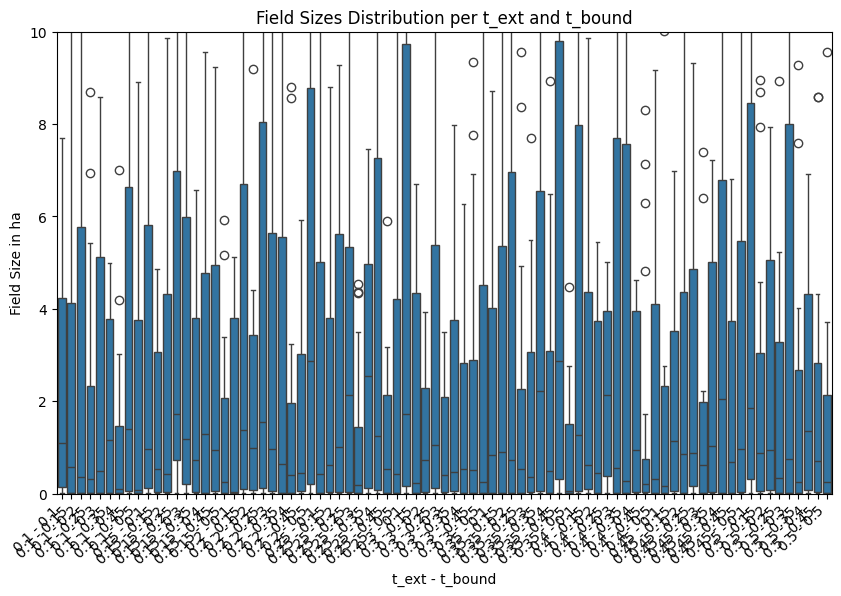

In [72]:
res = pd.read_csv('/data/fields/Auxiliary/grid_search/256_20_masked_chipsvrt_GSA-DE_BRB-2019_All_agromask_linecrop_prediction_extent_IoU_hyperparameter_tuning_full.csv')
res[res['field_sizes'] == 1]['IoU']

# Assuming 'res' is your DataFrame
# For visualization, you can create a combined column for 't_ext' and 't_bound'
res['t_ext_t_bound'] = res['t_ext'].astype(str) + ' - ' + res['t_bound'].astype(str)

# Create a boxplot
plt.figure(figsize=(10, 6))  # Set figure size
res['field_sizes'] = res['field_sizes'] / 100
print(res['field_sizes'])
sns.boxplot(data=res, x='t_ext_t_bound', y='field_sizes')

# Add labels and title
plt.title('Field Sizes Distribution per t_ext and t_bound')
plt.xlabel('t_ext - t_bound')
plt.ylabel('Field Size in ha')
# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 10) 
# Show the plot
plt.show()


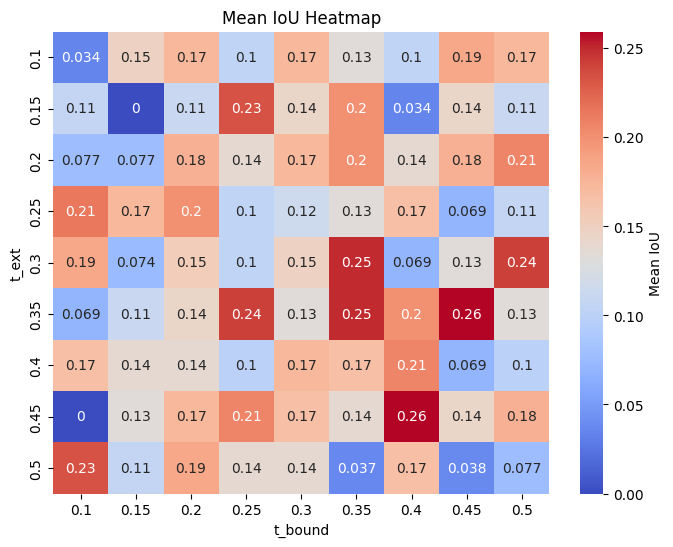

In [115]:
res = pd.read_csv('/data/fields/Auxiliary/grid_search/256_20_masked_chipsvrt_GSA-DE_BRB-2019_All_agromask_linecrop_prediction_extent_IoU_hyperparameter_tuning_full.csv')
# Group by 't_ext' and 't_bound', and calculate the mean and median of 'mean_IoU'
# Filter the rows where field_sizes > 1
filtered_df = res[res['field_sizes'] > 0]

# Group by 't_ext' and 't_bound' and calculate the mean and median of IoU
grouped_stats = filtered_df.groupby(['t_ext', 't_bound'])['IoU'].agg(['mean', 'median']).reset_index()

# Count IoU values greater than 0.5 and 0.8 and divide by the total count per group
# Define a function to calculate ratios for both thresholds
def calculate_ratios(x):
    ratio_05 = (x > 0.5).sum() / len(x)
    ratio_08 = (x > 0.8).sum() / len(x)
    return pd.Series({'IoU_50': ratio_05, 'IoU_80': ratio_08})

# Group by 't_ext' and 't_bound' and apply the function
ratios = res.groupby(['t_ext', 't_bound'])['IoU'].apply(calculate_ratios).reset_index()
# Pivot the 'ratios' DataFrame to create separate columns for 'IoU_50' and 'IoU_80'
ratios_pivoted = ratios.pivot(index=['t_ext', 't_bound'], columns='level_2', values='IoU')

# Reset the index to flatten the DataFrame
ratios_pivoted = ratios_pivoted.reset_index()
# merge grouped_stats with the 2 calculated columns
merged_df = pd.merge(grouped_stats, ratios_pivoted, on=['t_ext', 't_bound'])


# Pivot the merged DataFrame for heatmap plotting
heatmap_data = merged_df.pivot(index='t_ext', columns='t_bound', values='IoU_80')

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', cbar_kws={'label': 'Mean IoU'})
plt.title('Mean IoU Heatmap')
plt.xlabel('t_bound')
plt.ylabel('t_ext')
plt.show()

In [109]:
print(ratios)

     t_ext  t_bound level_2       IoU
0      0.1     0.10  IoU_50  0.275862
1      0.1     0.10  IoU_80  0.034483
2      0.1     0.15  IoU_50  0.407407
3      0.1     0.15  IoU_80  0.148148
4      0.1     0.20  IoU_50  0.379310
..     ...      ...     ...       ...
157    0.5     0.40  IoU_80  0.166667
158    0.5     0.45  IoU_50  0.269231
159    0.5     0.45  IoU_80  0.038462
160    0.5     0.50  IoU_50  0.153846
161    0.5     0.50  IoU_80  0.076923

[162 rows x 4 columns]


In [108]:
print(ratios_pivoted)

level_2  t_ext  t_bound    IoU_50    IoU_80
0          0.1     0.10  0.275862  0.034483
1          0.1     0.15  0.407407  0.148148
2          0.1     0.20  0.379310  0.172414
3          0.1     0.25  0.275862  0.103448
4          0.1     0.30  0.517241  0.172414
..         ...      ...       ...       ...
76         0.5     0.30  0.310345  0.137931
77         0.5     0.35  0.222222  0.037037
78         0.5     0.40  0.400000  0.166667
79         0.5     0.45  0.269231  0.038462
80         0.5     0.50  0.153846  0.076923

[81 rows x 4 columns]


In [ ]:
# # Plot the heatmap
# # Pivot the dataframe to create a matrix for the heatmap
# heatmap_data = res.pivot(index='t_ext', columns='t_bound', values='mean_IoU')

# # Plot the heatmap
# plt.figure(figsize=(8, 6))
# sns.heatmap(heatmap_data, annot=True, cmap='viridis')
# plt.title('Mean IoU Heatmap')
# plt.xlabel('t_bound')
# plt.ylabel('t_ext')
# plt.gca().invert_yaxis()
# plt.show()

# # Scatter plot
# plt.figure(figsize=(8, 6))
# sns.scatterplot(x='t_ext', y='t_bound', size='mean_IoU', data=res, hue='mean_IoU', palette='viridis', sizes=(50, 200))
# plt.title('Scatter Plot of Mean IoU')
# plt.xlabel('t_ext')
# plt.ylabel('t_bound')
# plt.show()

0.27586206896551724